In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!pip install kagglehub

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alaaomar02","key":"b202336fd8c9efd2bf6df056972aa17a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors


In [ ]:
import zipfile
import os

dataset_zip = "garbage-classification.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("garbage_classification")

data_dir = "garbage_classification/Garbage classification/Garbage classification"
print(os.listdir(data_dir))

['metal', 'paper', 'trash', 'glass', 'cardboard', 'plastic']


## Transformation

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = ImageFolder(data_dir)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

# Function to show sample
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    img_tensor = ToTensor()(img)
    plt.imshow(img_tensor.permute(1, 2, 0))

Label: cardboard (Class No: 0)


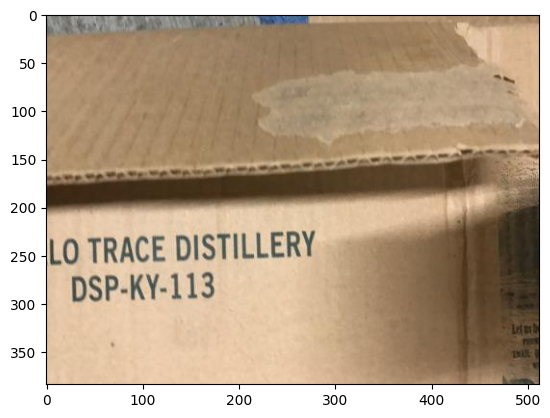

In [ ]:
img, label = dataset[12]
show_sample(img, label)

## Loading and Splitting Data:

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])

train_ds.dataset.transform = train_transforms
val_ds.dataset.transform = val_transforms
test_ds.dataset.transform = val_transforms

# Verify the split sizes
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

## Model Base:

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

# **Resnet50**

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


## Portibg to GPU:

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

## Training The Model:

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
@torch.no_grad()
def print_metrics(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in val_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    # Print Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

In [ ]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        correct = 0
        total = 0

        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)  # Get the class index with max probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        accuracy = correct / total
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = accuracy
        model.epoch_end(epoch, result)
        history.append(result)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {result['train_loss']:.4f}, Train Accuracy: {result['train_accuracy']*100:.2f}%")

    return history

In [ ]:
model = to_device(ResNet(), device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.7832638025283813, 'val_acc': 0.1892361044883728}

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4659, val_loss: 1.2737, val_acc: 0.8438
Epoch [1/8], Train Loss: 1.4659, Train Accuracy: 68.42%
Epoch 2: train_loss: 1.1751, val_loss: 1.1589, val_acc: 0.9288
Epoch [2/8], Train Loss: 1.1751, Train Accuracy: 92.15%
Epoch 3: train_loss: 1.0977, val_loss: 1.1321, val_acc: 0.9427
Epoch [3/8], Train Loss: 1.0977, Train Accuracy: 97.61%
Epoch 4: train_loss: 1.0717, val_loss: 1.1229, val_acc: 0.9444
Epoch [4/8], Train Loss: 1.0717, Train Accuracy: 99.12%
Epoch 5: train_loss: 1.0629, val_loss: 1.1117, val_acc: 0.9531
Epoch [5/8], Train Loss: 1.0629, Train Accuracy: 99.44%
Epoch 6: train_loss: 1.0572, val_loss: 1.1095, val_acc: 0.9497
Epoch [6/8], Train Loss: 1.0572, Train Accuracy: 99.81%
Epoch 7: train_loss: 1.0545, val_loss: 1.1195, val_acc: 0.9427
Epoch [7/8], Train Loss: 1.0545, Train Accuracy: 99.81%
Epoch 8: train_loss: 1.0569, val_loss: 1.1266, val_acc: 0.9149
Epoch [8/8], Train Loss: 1.0569, Train Accuracy: 99.44%


Evaluating on test set...


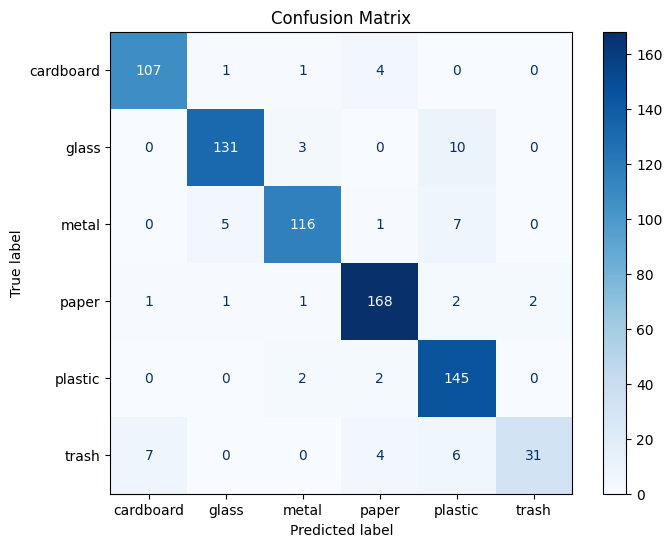


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.93      0.95      0.94       113
       glass       0.95      0.91      0.93       144
       metal       0.94      0.90      0.92       129
       paper       0.94      0.96      0.95       175
     plastic       0.85      0.97      0.91       149
       trash       0.94      0.65      0.77        48

    accuracy                           0.92       758
   macro avg       0.93      0.89      0.90       758
weighted avg       0.92      0.92      0.92       758



In [ ]:
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

@torch.no_grad()
def evaluate_test_set(model, test_loader, class_names):
    print("Evaluating on test set...")
    print_metrics(model, test_loader, class_names)

evaluate_test_set(model, test_dl, dataset.classes)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

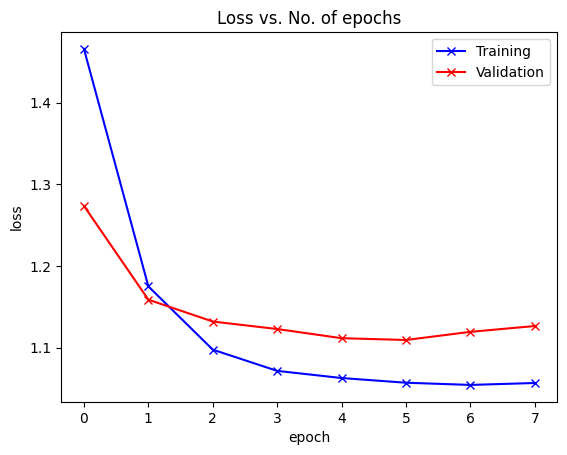

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


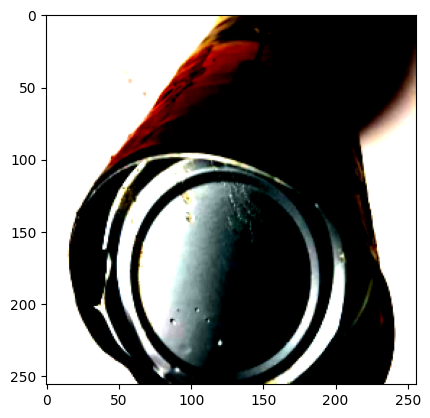

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


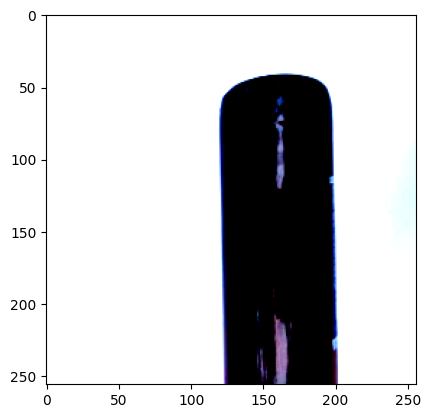

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))